# Library loading

First, we load all the libraries that we will use in this notebook and set some options.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

warnings.filterwarnings("ignore")

Then, we open the database from the liga.sqlite file and save it to a dataframe named "df". We chack for completely empty rows and, if there's any, we drop them.

In [2]:
conn = sqlite3.connect('../laliga.sqlite')
df = pd.read_sql_query("SELECT * FROM Matches", conn)
df = df.dropna(axis = 'index' , how = 'all')
display(df.head())
display(df.tail())

# Close the connection when done
conn.close()

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2


,season,division,matchday,date,time,home_team,away_team,score
48775,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None
48776,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None
48777,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None
48778,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None
48779,2021-2022,2,42,5/29/22,None,Real Valladolid,SD Huesca,None


Since there are several matches that don't have score (they haven't been played when the database was extracted), we have to get rid of them because they don't give any useful information. Moreover, as the matchday 3 of season 2021-2022 is not complete, we also delete it.

In [3]:
df = df[~((df['season'] == "2021-2022") & (df['matchday'] > 2))]
df.tail()

,season,division,matchday,date,time,home_team,away_team,score
48335,2021-2022,2,2,8/22/21,7:30 PM,SD Eibar,Ponferradina,0:1
48336,2021-2022,2,2,8/22/21,7:30 PM,Girona,UD Las Palmas,0:0
48337,2021-2022,2,2,8/22/21,10:00 PM,SD Huesca,FC Cartagena,2:0
48338,2021-2022,2,2,8/23/21,8:00 PM,CD Mirandés,SD Amorebieta,2:0
48339,2021-2022,2,2,8/23/21,10:00 PM,CD Leganés,Burgos CF,0:0


# Data exploration

First of all, we should know the data types of each column.

In [4]:
df.dtypes

season       object
division      int64
matchday      int64
date         object
time         object
home_team    object
away_team    object
score        object
dtype: object

How many teams do we have?

In [5]:
print(f"We have {len(df['home_team'].unique())} teams that have played at home.")
print(f"We have {len(df['away_team'].unique())} teams that have played as visitors.")
print(f"And those teams are:\n {df['home_team'].unique()}.")

We have 151 teams that have played at home.
We have 152 teams that have played as visitors.
And those teams are:
 ['Arenas Club' 'Espanyol' 'Real Madrid' 'Donostia' 'Racing' 'Barcelona'
 'Athletic' 'Athletic Madrid' 'Real Unión' 'Catalunya' 'Alavés' 'Valencia'
 'Real Betis' 'Real Oviedo' 'Sevilla FC' 'Hércules CF' 'CA Osasuna'
 'Real Zaragoza' 'Celta de Vigo' 'Ath. Aviación' 'Real Murcia'
 'Atl. Aviación' 'Granada CF' 'Dep. La Coruña' 'Real Sociedad'
 'CD Castellón' 'CE Sabadell ' 'Real Gijón' 'CD Alcoyano' 'Gimnàstic'
 'Atlético Madrid' 'Real Valladolid' 'CD Málaga' 'Lérida'
 'Atlético Tetuán' 'UD Las Palmas' 'Real Jaén CF' 'CyD Leonesa'
 'CD Condal' 'Elche CF' 'RCD Mallorca' 'CD Tenerife' 'Córdoba CF'
 'Pontevedra' 'Levante' 'Sporting Gijón' 'Burgos CF' 'UD Salamanca'
 'Cádiz CF' 'Rayo Vallecano' 'Recr. Huelva' 'AD Almería' 'CD Logroñés'
 'Albacete' 'UE Lleida' 'SD Compostela' 'CP Mérida' 'CF Extremadura'
 'Villarreal' 'Málaga CF' 'CD Numancia' 'Getafe' 'UD Almería' 'Xerez CD'
 'SD E

As we can notice, we have one team that has played as a visitor but never as a local. This one is the `SD Amorebieta` that was promoted to 2nd division for the first time in 2021, but played the first two matches as a visitor.

However, upon further research, we found that some of the names correspond to the same team, which underwent renaming or rebranding. To address this, we should standardize the names to ensure consistency. We consider a team to remain the same after a rebranding, as there are instances where teams have disappeared, and their spots were filled by their second teams, which were not affiliated at the time and thus were not legally the same team.

In [6]:
df['home_team'] = df['home_team'].apply(lambda x: 'Atlético Madrid' if x == 'Athletic Madrid'
                                         else 'Real Sociedad' if x == 'Donostia'
                                         else 'CE Europa' if x == 'Catalunya'
                                         else 'Atlético Madrid' if x == 'Ath. Aviación'
                                         else 'Atlético Madrid' if x == 'Atl. Aviación'
                                         else 'UE Lleida' if x == 'Lérida'
                                         else 'UD Almería' if x == 'AD Almería'
                                         else 'Sporting Gijón' if x == 'Real Gijón'
                                         else 'Gimnàstic' if x == 'Gimnástica'
                                         else 'Ciudad Murcia' if x == 'Granada 74 CF'
                                         else 'UD Las Palmas' if x == 'Uni. Las Palmas'
                                         else 'Racing Ferrol' if x == 'Ferrol'
                                         else 'Terrassa FC' if x == 'Tarrasa'
                                         else 'Barcelona B' if x == 'Barcelona Atl.'
                                         else 'RM Castilla' if x == 'Castilla CF'
                                         else x)

df['away_team'] = df['away_team'].apply(lambda x: 'Atlético Madrid' if x == 'Athletic Madrid'
                                         else 'Real Sociedad' if x == 'Donostia'
                                         else 'CE Europa' if x == 'Catalunya'
                                         else 'Atlético Madrid' if x == 'Ath. Aviación'
                                         else 'Atlético Madrid' if x == 'Atl. Aviación'
                                         else 'UE Lleida' if x == 'Lérida'
                                         else 'UD Almería' if x == 'AD Almería'
                                         else 'Sporting Gijón' if x == 'Real Gijón'
                                         else 'Gimnàstic' if x == 'Gimnástica'
                                         else 'Ciudad Murcia' if x == 'Granada 74 CF'
                                         else 'UD Las Palmas' if x == 'Uni. Las Palmas'
                                         else 'Racing Ferrol' if x == 'Ferrol'
                                         else 'Terrassa FC' if x == 'Tarrasa'
                                         else 'Barcelona B' if x == 'Barcelona Atl.'
                                         else 'RM Castilla' if x == 'Castilla CF'
                                        else x)

print(f"We have {len(df['home_team'].unique())} teams that have played at home.")
print(f"We have {len(df['away_team'].unique())} teams that have played as visitors.")
print(f"And those teams are:\n {df['home_team'].unique()}.")

We have 136 teams that have played at home.
We have 137 teams that have played as visitors.
And those teams are:
 ['Arenas Club' 'Espanyol' 'Real Madrid' 'Real Sociedad' 'Racing'
 'Barcelona' 'Athletic' 'Atlético Madrid' 'Real Unión' 'CE Europa'
 'Alavés' 'Valencia' 'Real Betis' 'Real Oviedo' 'Sevilla FC' 'Hércules CF'
 'CA Osasuna' 'Real Zaragoza' 'Celta de Vigo' 'Real Murcia' 'Granada CF'
 'Dep. La Coruña' 'CD Castellón' 'CE Sabadell ' 'Sporting Gijón'
 'CD Alcoyano' 'Gimnàstic' 'Real Valladolid' 'CD Málaga' 'UE Lleida'
 'Atlético Tetuán' 'UD Las Palmas' 'Real Jaén CF' 'CyD Leonesa'
 'CD Condal' 'Elche CF' 'RCD Mallorca' 'CD Tenerife' 'Córdoba CF'
 'Pontevedra' 'Levante' 'Burgos CF' 'UD Salamanca' 'Cádiz CF'
 'Rayo Vallecano' 'Recr. Huelva' 'UD Almería' 'CD Logroñés' 'Albacete'
 'SD Compostela' 'CP Mérida' 'CF Extremadura' 'Villarreal' 'Málaga CF'
 'CD Numancia' 'Getafe' 'Xerez CD' 'SD Eibar' 'CD Leganés' 'Girona'
 'SD Huesca' 'Baracaldo' 'Racing Ferrol' 'Avilés Ind.' 'SD Ceuta'
 'CE

We can check the divisions seasons we have in the data frame.

In [7]:
print(f"The dataset has {len(df['division'].unique())} divisions.")
print(f"The dataset contains info from {len(df['season'].unique())} seasons.")

The dataset has 2 divisions.
The dataset contains info from 91 seasons.


We can also check the different scores the dataset has:

In [8]:
df["score"].unique()

array(['2:3', '3:2', '5:0', '1:1', '0:2', '1:2', '9:0', '0:3', '3:1',
       '5:2', '3:0', '0:4', '2:1', '2:2', '2:0', '3:3', '4:1', '1:3',
       '1:0', '4:0', '6:3', '8:1', '5:1', '4:3', '4:2', '0:1', '0:0',
       '5:4', '7:1', '6:1', '5:3', '7:0', '2:5', '2:4', '6:0', '4:4',
       '1:4', '7:2', '1:7', '8:2', '3:4', '6:2', '0:6', '12:1', '4:7',
       '1:5', '6:4', '9:1', '9:5', '8:0', '7:3', '8:3', '3:5', '0:5',
       '2:6', '4:5', '7:5', '11:1', '10:3', '10:0', '5:5', '9:2', '9:3',
       '3:6', '7:4', '2:7', '10:1', '6:6', '1:6', '9:4', '5:6', '0:7',
       '1:8', '0:8', '11:2', '4:6', '2:8', '3:8', '10:2', '14:2', '6:5',
       '3:7', '11:0'], dtype=object)

# Create some features

ERASE THIS WHEN FINISHED
- Scores and results
- Rank of 2nd tier teams
- Mean rank of the last 5 seasons
- Number of teams of the second divison

To start, we split the data contained within the `score` column into the performance of the team playing at home (`home_score`) and the team playing as visitors (`away_score`).

In [9]:
df[['home_score', 'away_score']] = df['score'].str.split(':', expand=True)
df['home_score'] = pd.to_numeric(df['home_score'])
df['away_score'] = pd.to_numeric(df['away_score'])

We changed the `season` column to numerical to ease later steps when calculating teams' performance.

In [10]:
df["season"] = pd.to_numeric(df["season"].str[-4:])

Using the `score` of the `away_team` and the `home_team` we can compute the `result` of each match. This is encoded in the classic La Quiniela notation, where a home win is `1`, an away win is `2` and a tie corresponds to `X`.

In [11]:
df['result'] = df.apply(lambda df: '1' if df['home_score'] > df['away_score']
                                        else '2' if df['home_score'] < df['away_score']
                                        else 'X', axis=1)

Next we will create two new data frames in order to store the data for the teams when playing at home an when they play as visitors. Once we have them, we concatenate them putting zeros where there is no information availiable.

In [12]:
df['home_W'] = (df['result'] == '1').astype(int)
df['home_L'] = (df['result'] == '2').astype(int)
df['home_T'] = (df['result'] == 'X').astype(int)
df['away_W'] = (df['result'] == '2').astype(int)
df['away_L'] = (df['result'] == '1').astype(int)
df['away_T'] = (df['result'] == 'X').astype(int)

home_df = df[['season', 'division', 'matchday', 'home_team', 'home_score', 'away_score','home_score', 'away_score', 'home_W', 'home_L', 'home_T']]
home_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA','home_GF', 'home_GA', 'W', 'L', 'T']

away_df = df[['season', 'division', 'matchday', 'away_team', 'away_score', 'home_score','away_score', 'home_score', 'away_W', 'away_L', 'away_T']]
away_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA','away_GF', 'away_GA', 'W', 'L', 'T']

team_results = pd.concat([home_df, away_df])
team_results.fillna(0,inplace=True)

Then, we store in the `matchday_standings` dataframe the cummulatives of the different variables to have the information of the previous matches of the season for each team. We also compute the goal difference, the number of matches played and the points for each of them. 

In [13]:
matchday_standings = team_results.sort_values(['season', 'division', 'team', 'matchday'])
matchday_standings[['GF', 'GA','home_GF',
                    'home_GA','away_GF','away_GA', 
                    'W', 'L', 'T']] = matchday_standings.groupby(['season', 'division', 'team'])[['GF', 'GA','home_GF',
                                                                                                  'home_GA','away_GF','away_GA', 
                                                                                                  'W', 'L', 'T']].cumsum()

matchday_standings['GD'] = matchday_standings['GF'] - matchday_standings['GA']
matchday_standings['M'] = matchday_standings['W'] + matchday_standings['L'] + matchday_standings['T']
matchday_standings['Pts'] = matchday_standings['W'] * 3 + matchday_standings['T']

We have also created a column to store the last five results for each team (`last_5`), encoded by `W` for a win, `T` for a tie and `L` for a defeat. We add them to each team of the `matchday_standings` dataframe, together with their `rank` at the corresponding `season`, `division` and `matchday`.

In [14]:
team_results['result'] = team_results.apply(lambda row: 'W' if row['W'] == 1 else 'L' if row['L'] == 1 else 'T', axis=1)
team_results.sort_values(['season', 'division', 'team', 'matchday'],inplace = True)

last_results = team_results.groupby(['season', 'division', 'team'])['result'].apply(
    lambda x: np.array([np.array(rolling_list) for rolling_list in x.rolling(5)],dtype=object))
matchday_standings["last_5"] = np.concatenate(last_results.values).reshape(-1)

matchday_standings = matchday_standings.sort_values(by=['season','division', 'matchday',
                                                  'Pts', 'GD', 'GF'],
                                              ascending=[True, True,True,
                                                         False, False, False])


matchday_standings.insert(3,'rank',matchday_standings.groupby(['season','division',
                                                   'matchday'])['Pts'].rank(ascending=False,
                                                                            method='first'))

We compute the cumulative average goals as they can be good parameters to describe a team's seasonal performance.

In [15]:
matchday_standings['home_avg_GF'] = matchday_standings['home_GF']/ matchday_standings['matchday']
matchday_standings['home_avg_GA'] = matchday_standings['home_GA']/ matchday_standings['matchday']
matchday_standings['away_avg_GF'] = matchday_standings['away_GF'] / matchday_standings['matchday']
matchday_standings['away_avg_GA'] = matchday_standings['away_GA'] / matchday_standings['matchday']
matchday_standings['avg_GF'] = matchday_standings['GF'] / matchday_standings['matchday']
matchday_standings['avg_GA'] = matchday_standings['GA'] / matchday_standings['matchday']

We can also calculate the points earned in the last five games. To do it, we create a function that reads the `last_5` results, and sums the corresponding points.

In [16]:
def calculate_points(last_5):
    points = {'W': 3, 'T': 1, 'L': 0}
    total_points = sum(points[res] for res in last_5 if res in points)
    return total_points / len(last_5) if len(last_5) > 0 else 0

matchday_standings['avg_points_last_5'] = matchday_standings['last_5'].apply(calculate_points)

The variable `rank_5_last_seasons` describes the rank of each team during the last 5 seasons. After computing it, we merge this variable to `matchday_standings` data frame.

In [17]:
last_game_rankings = matchday_standings.sort_values(by=['season', 'division',
                                                        'team', 'matchday']).groupby(['season',
                                                                                      'division', 'team']).last().reset_index()
last_game_rankings.loc[last_game_rankings['division'] == 2, 'rank'] += 20
last_game_rankings["rank_5_last_seasons"] = last_game_rankings.groupby('team')['rank'].transform(lambda x: x.rolling(window=5,
                                                                                                                     min_periods=1).mean())

last_game_rankings["season"] = last_game_rankings["season"] + 1

matchday_standings = matchday_standings.merge(
    last_game_rankings[['season', 'division', 'team', 'rank_5_last_seasons']],
    on=['season', 'division', 'team'],
    how='left')

matchday_standings

,season,division,matchday,rank,team,GF,GA,home_GF,home_GA,W,...,Pts,last_5,home_avg_GF,home_avg_GA,away_avg_GF,away_avg_GA,avg_GF,avg_GA,avg_points_last_5,rank_5_last_seasons
0,1929,1,1,1.0,Real Madrid,5,0,5.0,0.0,1,...,3,[W],5.0,0.0,0.0,0.0,5.0,0.0,3.0,NaN
1,1929,1,1,2.0,Barcelona,2,0,0.0,0.0,1,...,3,[W],0.0,0.0,2.0,0.0,2.0,0.0,3.0,NaN
2,1929,1,1,3.0,Atlético Madrid,3,2,0.0,0.0,1,...,3,[W],0.0,0.0,3.0,2.0,3.0,2.0,3.0,NaN
3,1929,1,1,4.0,Espanyol,3,2,3.0,2.0,1,...,3,[W],3.0,2.0,0.0,0.0,3.0,2.0,3.0,NaN
4,1929,1,1,5.0,Athletic,1,1,0.0,0.0,0,...,1,[T],0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95955,2022,2,2,18.0,Real Zaragoza,0,2,0.0,0.0,0,...,1,"[T, L]",0.0,0.0,0.0,1.0,0.0,1.0,0.5,30.6
95956,2022,2,2,19.0,Alcorcón,0,3,0.0,2.0,0,...,0,"[L, L]",0.0,1.0,0.0,0.5,0.0,1.5,0.0,34.4
95957,2022,2,2,20.0,SD Eibar,0,3,0.0,1.0,0,...,0,"[L, L]",0.0,0.5,0.0,1.0,0.0,1.5,0.0,NaN
95958,2022,2,2,21.0,FC Cartagena,1,5,1.0,3.0,0,...,0,"[L, L]",0.5,1.5,0.0,1.0,0.5,2.5,0.0,33.5


It is observed that several rows lack records for the last 5 seasons' ranks. This is due to various reasons, the most common of which are:

- Some teams got promoted from 3rd division, so we don't have information about them.
- All entries from the first season (1929) are NaN since we don't have older registries in the database.

To enable sorting by season and team rank, we need to adjust the ranks for second-division teams. Since we calculated their maximum rank within each division, the index resets between divisions.

In [18]:
max_rank_by_season = matchday_standings.groupby(['season', 'division'])['rank'].max().reset_index()
max_rank_by_season.columns = ['season', 'division', 'max_rank']

max_rank_div1_by_season = matchday_standings[matchday_standings['division'] == 1].groupby('season')['rank'].max().reset_index()
max_rank_div1_by_season.columns = ['season', 'max_rank_div1']

matchday_standings = matchday_standings.merge(max_rank_by_season, on=['season', 'division'], how='left')
matchday_standings = matchday_standings.merge(max_rank_div1_by_season, on='season', how='left')

matchday_standings['rank_5_last_seasons'] = np.where(
    matchday_standings['rank_5_last_seasons'].isna(),
    np.where(
        matchday_standings['season'] == 1929, 
        0, 
        np.where(
            matchday_standings['division'] == 2,
            matchday_standings['max_rank_div1'] + matchday_standings['max_rank'] + 1,
            matchday_standings['max_rank'] + 1  
        )
    ),
    matchday_standings['rank_5_last_seasons']
)


matchday_standings.drop(columns=['max_rank', 'max_rank_div1'],inplace=True)

display(matchday_standings)

,season,division,matchday,rank,team,GF,GA,home_GF,home_GA,W,...,Pts,last_5,home_avg_GF,home_avg_GA,away_avg_GF,away_avg_GA,avg_GF,avg_GA,avg_points_last_5,rank_5_last_seasons
0,1929,1,1,1.0,Real Madrid,5,0,5.0,0.0,1,...,3,[W],5.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0
1,1929,1,1,2.0,Barcelona,2,0,0.0,0.0,1,...,3,[W],0.0,0.0,2.0,0.0,2.0,0.0,3.0,0.0
2,1929,1,1,3.0,Atlético Madrid,3,2,0.0,0.0,1,...,3,[W],0.0,0.0,3.0,2.0,3.0,2.0,3.0,0.0
3,1929,1,1,4.0,Espanyol,3,2,3.0,2.0,1,...,3,[W],3.0,2.0,0.0,0.0,3.0,2.0,3.0,0.0
4,1929,1,1,5.0,Athletic,1,1,0.0,0.0,0,...,1,[T],0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95955,2022,2,2,18.0,Real Zaragoza,0,2,0.0,0.0,0,...,1,"[T, L]",0.0,0.0,0.0,1.0,0.0,1.0,0.5,30.6
95956,2022,2,2,19.0,Alcorcón,0,3,0.0,2.0,0,...,0,"[L, L]",0.0,1.0,0.0,0.5,0.0,1.5,0.0,34.4
95957,2022,2,2,20.0,SD Eibar,0,3,0.0,1.0,0,...,0,"[L, L]",0.0,0.5,0.0,1.0,0.0,1.5,0.0,43.0
95958,2022,2,2,21.0,FC Cartagena,1,5,1.0,3.0,0,...,0,"[L, L]",0.5,1.5,0.0,1.0,0.5,2.5,0.0,33.5


We then split the features computed in two dataframes: one with the stats when playing at home, and the other one with the stats when playing away. Then, we rename some of the columns to be more precise with their names and to avoid possible mistakes.

In [19]:
home_stats = matchday_standings[['season', 'division', 'matchday', 'team', 'rank', 
                                                       'avg_GF', 'avg_GA', 'home_avg_GF', 'home_avg_GA', 
                                                       'avg_points_last_5','rank_5_last_seasons']]
        
away_stats = matchday_standings[['season', 'division', 'matchday', 'team', 'rank', 
                                                'avg_GF', 'avg_GA', 'away_avg_GF', 'away_avg_GA', 
                                                'avg_points_last_5','rank_5_last_seasons']]

home_stats = home_stats.rename(columns={
    'team': 'home_team',
    'rank': 'home_rank',
    'avg_GF': 'home_total_avg_GF',
    'avg_GA': 'home_total_avg_GA',
    'home_avg_GF': 'home_GF_avg',
    'home_avg_GA': 'home_GA_avg',
    'avg_points_last_5': 'home_avg_points_last_5',
    'rank_5_last_seasons' : 'home_rank_5_last_seasons'
})

away_stats = away_stats.rename(columns={
    'team': 'away_team',
    'rank': 'away_rank',
    'avg_GF': 'away_total_avg_GF',
    'avg_GA': 'away_total_avg_GA',
    'away_avg_GF': 'away_GF_avg',
    'away_avg_GA': 'away_GA_avg',
    'avg_points_last_5': 'away_avg_points_last_5',
    'rank_5_last_seasons' : 'away_rank_5_last_seasons'
})

And then we merge the data frames to the original data frame to store all the features we have calculated for the teams when playing at home and as visitors. Since we want to add at each matchday the information about the previous ones, we have to merge them considering the previous matchday from the original dataframe `df`.

In [20]:
df["matchday"] = df["matchday"] - 1
df = df.merge(home_stats, on=['season', 'division', 'matchday', 'home_team'], how='left')
df = df.merge(away_stats, on=['season', 'division', 'matchday', 'away_team'], how='left')
df["matchday"] = df["matchday"] + 1

# Reorder the columns
df = df[["season","division","matchday","home_team","away_team","result","home_score","away_score","home_W","home_L","home_T","home_rank","away_rank",
         "home_total_avg_GA","home_total_avg_GF","away_total_avg_GA","away_total_avg_GF","home_GF_avg",
         "home_GA_avg","away_GF_avg","away_GA_avg","home_avg_points_last_5","away_avg_points_last_5",
         "home_rank_5_last_seasons","away_rank_5_last_seasons"]]
df.fillna(0,inplace=True)

We can compute other useful features using the previous ones. Among these there are the `expected_home_goals` and `expected_away_goals`, which is the mean between the goals the corresponding team scores and the goals concedes by the rival. We also compute the difference between the mean of the last 5 seasons between the two teams.

In [21]:
df["dif_rank"] = df["home_rank"] - df["away_rank"]
df["expected_home_goals"] = (df["home_GF_avg"] + df["away_GA_avg"])/2
df["expected_away_goals"] = (df["away_GF_avg"] + df["home_GA_avg"])/2
df["dif_last5_points"] = df["home_avg_points_last_5"] - df["away_avg_points_last_5"]
df["avg_home_goals_total"] = (df["home_total_avg_GF"] + df["away_total_avg_GA"])/2
df["avg_away_goals_total"] = (df["away_total_avg_GF"] + df["home_total_avg_GA"])/2
df["dif_previous_ranks"] = df["home_rank_5_last_seasons"] - df["away_rank_5_last_seasons"]

df.fillna(0)

,season,division,matchday,home_team,away_team,result,home_score,away_score,home_W,home_L,...,away_avg_points_last_5,home_rank_5_last_seasons,away_rank_5_last_seasons,dif_rank,expected_home_goals,expected_away_goals,dif_last5_points,avg_home_goals_total,avg_away_goals_total,dif_previous_ranks
0,1929,1,1,Arenas Club,Atlético Madrid,2,2,3,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1929,1,1,Espanyol,Real Unión,1,3,2,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1929,1,1,Real Madrid,CE Europa,1,5,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1929,1,1,Real Sociedad,Athletic,X,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1929,1,1,Racing,Barcelona,2,0,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47979,2022,2,2,SD Eibar,Ponferradina,2,0,1,0,1,...,3.0,43.0,33.8,17.0,0.0,0.0,-3.0,0.0,1.5,9.2
47980,2022,2,2,Girona,UD Las Palmas,X,0,0,0,0,...,1.0,20.0,24.6,-9.0,1.0,0.0,2.0,1.5,0.5,-4.6
47981,2022,2,2,SD Huesca,FC Cartagena,1,2,0,1,0,...,0.0,43.0,33.5,-17.0,1.0,0.0,3.0,2.5,0.5,9.5
47982,2022,2,2,CD Mirandés,SD Amorebieta,1,2,0,1,0,...,0.0,33.4,43.0,-9.0,1.0,0.0,1.0,1.0,0.0,-9.6


We have also added some features related with the direct confrontations between the two teams (usually known as Head to Head, H2H). The fuction below sums for the last 10 times those teams played the number of victories, ties and goals for each team when this exact match happens. Then, we drop some columns that are not useful anymore and sort the data.

In [22]:
def calculate_H2H_stats(matches):
    matches = matches.sort_values('season')

     # Calculate rolling cumulative stats for the previous 10 matches
    matches['H2H_wins_home_last_10'] = (matches['home_team'] == matches['home_team'].iloc[0]) * matches['home_W'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_wins_away_last_10'] = (matches['away_team'] == matches['away_team'].iloc[0]) * matches['home_L'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_ties_last_10'] = matches['home_T'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_goals_home_last_10'] = (matches['home_team'] == matches['home_team'].iloc[0]) * matches['home_score'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_goals_away_last_10'] = (matches['away_team'] == matches['away_team'].iloc[0]) * matches['away_score'].shift().rolling(window=10, min_periods=0).sum()

    return matches

# Apply the function to each group of home and away team pairs.
df = df.groupby(['home_team', 'away_team'], group_keys=False).apply(calculate_H2H_stats)

df.drop(columns=["home_score","away_score","home_W","home_L","home_T"],inplace=True)

df = df.sort_values(by=['season','division','matchday'])

Finally, we split the data into training and test sets to feed into the machine learning algorithms.

In [23]:
df.columns

Index(['season', 'division', 'matchday', 'home_team', 'away_team', 'result',
       'home_rank', 'away_rank', 'home_total_avg_GA', 'home_total_avg_GF',
       'away_total_avg_GA', 'away_total_avg_GF', 'home_GF_avg', 'home_GA_avg',
       'away_GF_avg', 'away_GA_avg', 'home_avg_points_last_5',
       'away_avg_points_last_5', 'home_rank_5_last_seasons',
       'away_rank_5_last_seasons', 'dif_rank', 'expected_home_goals',
       'expected_away_goals', 'dif_last5_points', 'avg_home_goals_total',
       'avg_away_goals_total', 'dif_previous_ranks', 'H2H_wins_home_last_10',
       'H2H_wins_away_last_10', 'H2H_ties_last_10', 'H2H_goals_home_last_10',
       'H2H_goals_away_last_10'],
      dtype='object')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["season","division","result","home_team","away_team"],axis=1), df["result"], test_size=0.2, random_state=1)

# Model training

We first defined a `performance` function to compute, for each ML algorithm, the performance metrics, and then created an empty data frame to store them.

In [25]:
def performance(model, y_pred):
    # Classificatin Report shows some metrics to evaluate the model performance
    class_report = classification_report(y_test, y_pred, output_dict=True)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_score = scores.mean()
    print(f'Cross Validation scores: {scores}')
    print("Mean Score:", mean_score)
    print(classification_report(y_test, y_pred))
    accuracy = class_report['accuracy']

    # Plot Confusion Matrix
    labels = ["Home Win", "Away Win", "Tie"]
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, mean_score

# Empty df to store the performance of the different models
models_performance = pd.DataFrame(columns=['model', 'accuracy', 'cv_score_mean'])

## Gradient Boosting

Cross Validation scores: [0.53907268 0.54063558 0.53614693 0.53653771 0.53757978]
Mean Score: 0.5379945367133683
              precision    recall  f1-score   support

           1       0.55      0.97      0.70      5058
           2       0.48      0.13      0.21      2070
           X       0.33      0.01      0.02      2469

    accuracy                           0.54      9597
   macro avg       0.45      0.37      0.31      9597
weighted avg       0.47      0.54      0.42      9597



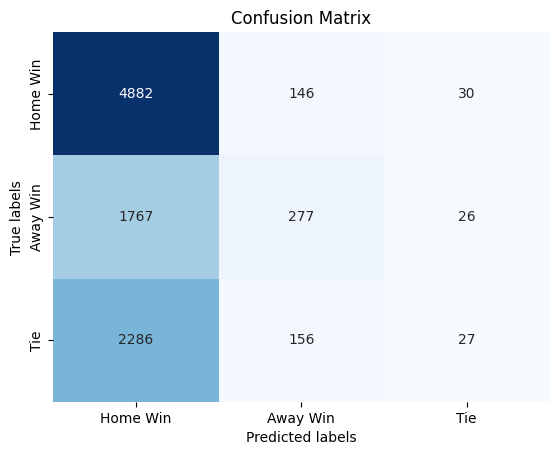

In [26]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_accuracy, gb_mean_score = performance(gb_model, gb_pred)
models_performance.loc[len(models_performance)] = [type(gb_model).__name__, gb_accuracy, gb_mean_score]

## Logistic Regression

Cross Validation scores: [0.53594686 0.53555613 0.53380227 0.53744952 0.53002475]
Mean Score: 0.5345559071773982
              precision    recall  f1-score   support

           1       0.55      0.96      0.70      5058
           2       0.46      0.14      0.21      2070
           X       0.37      0.02      0.04      2469

    accuracy                           0.54      9597
   macro avg       0.46      0.37      0.32      9597
weighted avg       0.48      0.54      0.42      9597



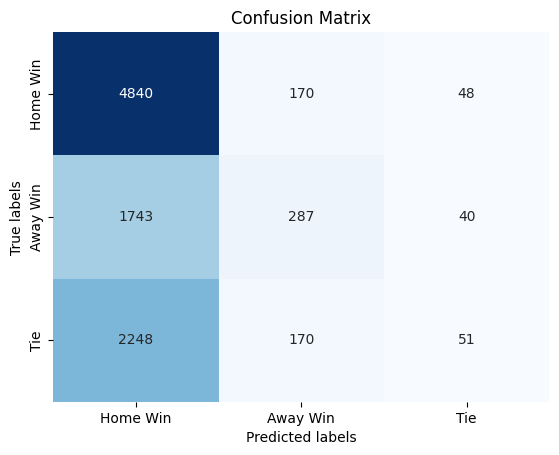

In [27]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
LR_pred = LR_model.predict(X_test)
LR_accuracy, LR_mean_score = performance(LR_model, LR_pred)
models_performance.loc[len(models_performance)] = [type(LR_model).__name__, LR_accuracy, LR_mean_score]

## Naive Bayes

Cross Validation scores: [0.45728054 0.46340193 0.45812166 0.46085711 0.45538622]
Mean Score: 0.4590094911431707
              precision    recall  f1-score   support

           1       0.63      0.54      0.59      5058
           2       0.34      0.35      0.34      2070
           X       0.30      0.38      0.34      2469

    accuracy                           0.46      9597
   macro avg       0.43      0.43      0.42      9597
weighted avg       0.48      0.46      0.47      9597



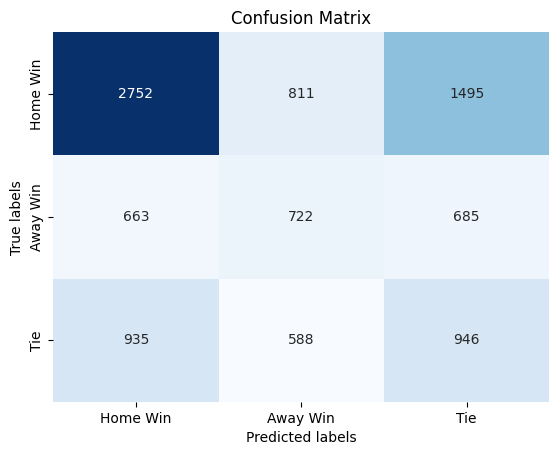

In [28]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)
NB_pred = NB_model.predict(X_test)
NB_accuracy, NB_mean_score = performance(NB_model, NB_pred)
models_performance.loc[len(models_performance)] = [type(NB_model).__name__, NB_accuracy, NB_mean_score]

## kNN

Cross Validation scores: [0.48749674 0.48879917 0.4876905  0.48651817 0.49264035]
Mean Score: 0.4886289879924347
              precision    recall  f1-score   support

           1       0.55      0.78      0.65      5058
           2       0.30      0.20      0.24      2070
           X       0.27      0.12      0.17      2469

    accuracy                           0.48      9597
   macro avg       0.37      0.37      0.35      9597
weighted avg       0.43      0.48      0.44      9597



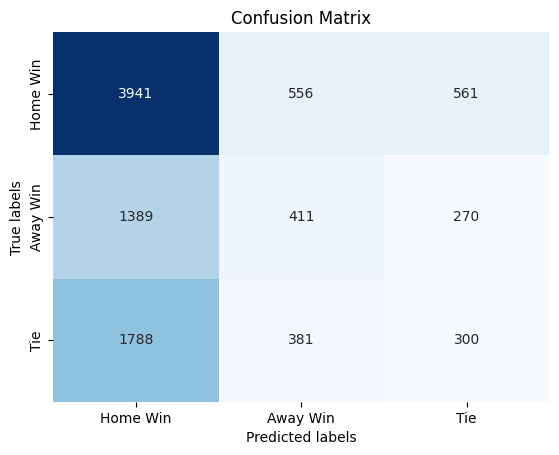

In [29]:
kNN_model = KNeighborsClassifier()
kNN_model.fit(X_train, y_train)
kNN_pred = kNN_model.predict(X_test)
kNN_accuracy, kNN_mean_score = performance(kNN_model, kNN_pred)
models_performance.loc[len(models_performance)] = [type(kNN_model).__name__, kNN_accuracy, kNN_mean_score]

## Decision Tree

Cross Validation scores: [0.4226361  0.42524095 0.42112804 0.41461508 0.41500586]
Mean Score: 0.4197252083613048
              precision    recall  f1-score   support

           1       0.57      0.56      0.56      5058
           2       0.25      0.25      0.25      2070
           X       0.28      0.29      0.28      2469

    accuracy                           0.42      9597
   macro avg       0.37      0.37      0.37      9597
weighted avg       0.42      0.42      0.42      9597



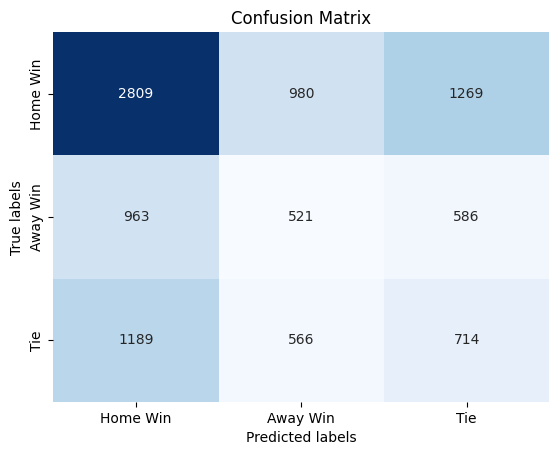

In [30]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
tree_accuracy, tree_mean_score = performance(tree_model, tree_pred)
models_performance.loc[len(models_performance)] = [type(tree_model).__name__, tree_accuracy, tree_mean_score]

## Random Forest

Cross Validation scores: [0.52826257 0.52357385 0.52455386 0.5279406  0.5244236 ]
Mean Score: 0.5257508965373001
              precision    recall  f1-score   support

           1       0.55      0.91      0.69      5058
           2       0.41      0.15      0.22      2070
           X       0.29      0.07      0.11      2469

    accuracy                           0.53      9597
   macro avg       0.42      0.37      0.34      9597
weighted avg       0.45      0.53      0.44      9597



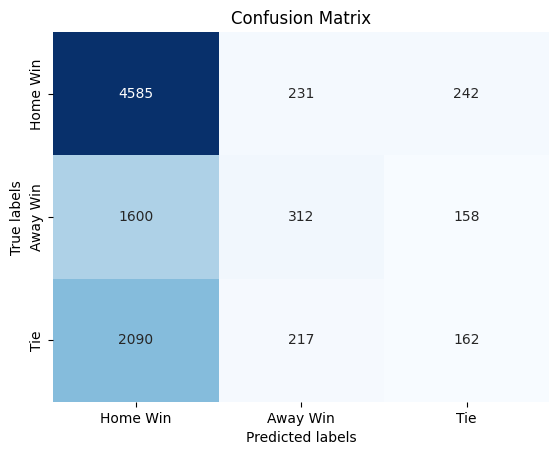

In [31]:
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)
RF_accuracy, RF_mean_score = performance(RF_model, RF_pred)
models_performance.loc[len(models_performance)] = [type(RF_model).__name__, RF_accuracy, RF_mean_score]

## Best model?

In [34]:
models_performance = models_performance.sort_values(['accuracy'], ascending=False)
print(models_performance)

                        model  accuracy  cv_score_mean
0  GradientBoostingClassifier  0.540377       0.537995
1          LogisticRegression  0.539544       0.534556
5      RandomForestClassifier  0.527144       0.525751
3        KNeighborsClassifier  0.484735       0.488629
2                  GaussianNB  0.460561       0.459009
4      DecisionTreeClassifier  0.421382       0.419725


## Feature Importance

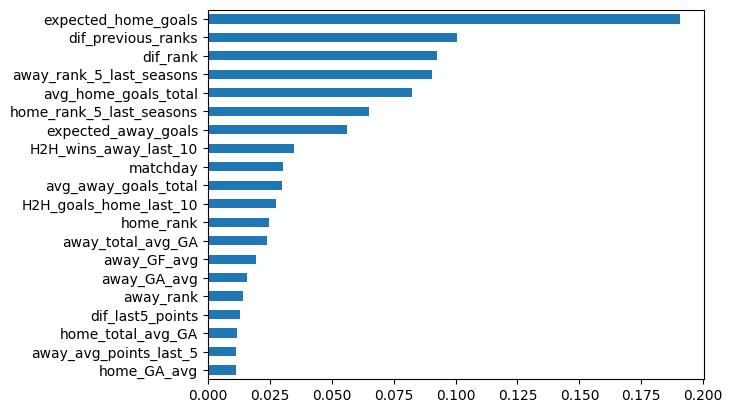

In [35]:
# Get the feature importance of the model
feature_imp = gb_model.feature_importances_

# Get the top 20 features
indices = np.argsort(feature_imp)[-20:][::-1]
feature_names = X_train.columns
feature_names = feature_names[indices]

# Plot
importances = pd.Series(feature_imp[indices], index=feature_names)
importances.sort_values(ascending=True).plot(kind="barh")
plt.show()